In [3]:
import time
import os
import math
from time import gmtime, strftime
from datetime import datetime
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data
from torchfoldext import FoldExt
import util
from dynamicplot import DynamicPlot
from IPython.core.debugger import set_trace

from data import ROctDataset
from ROctNetmodel_32 import ROctEncoder
from ROctNetmodel_32 import ROctDecoder
import ROctNetmodel_32

In [7]:
config = util.get_args()

#config.box_code_size = 2744
config.feature_size = 80
config.hidden_size = 200
  
config.show_log_every = 1
config.save_log = False
config.save_log_every = 3
config.save_snapshot = True
config.save_snapshot_every = 50
config.no_plot = False
config.no_cuda = True #False if using CUDA
config.cuda = not config.no_cuda
config.gpu = 1
config.data_path = 'data'
config.save_path = 'models'


config.batch_size = 1
config.epochs = 2000
incre = 1
n_samples = 1

# #for memory test
# config.batch_size = 50
# config.epochs = 2000
# incre = 100
# n_samples = 100

config.cuda = not config.no_cuda
if config.gpu<0 and config.cuda:
    config.gpu = 1
    torch.cuda.set_device(config.gpu)

if config.cuda and torch.cuda.is_available():
    print("Using CUDA on GPU ", config.gpu)
else:
    print("Not using CUDA.")

encoder = ROctEncoder(config)
decoder = ROctDecoder(config)

Not using CUDA.


/Volumes/One Touch/ROctNet/ROctNet-v11/ROctNetmodel_32.py:79: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/Volumes/One Touch/ROctNet/ROctNet-v11/ROctNetmodel_32.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/Volumes/One Touch/ROctNet/ROctNet-v11/ROctNetmodel_32.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/Volumes/One Touch/ROctNet/ROctNet-v11/ROctNetmodel_32.py:450: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/Volumes/One T

In [8]:
def my_collate(batch):
    return batch
# print("Loading data ...... ", flush=True)
# roct_data = ROctDataset('/data/juncheng/modelnet40/256_32_vox/train_1',1 , 7512)#7081 4441
# #roct_data.trees = roct_data.trees[0:-1:12]
# train_iter = torch.utils.data.DataLoader(roct_data, batch_size=config.batch_size, shuffle=True, collate_fn=my_collate)
# print("DONE")

# len(roct_data.trees)

In [9]:
# decoder = torch.load('models/ae_decoder_car_32.pkl')
# encoder = torch.load('models/ae_encoder_car_32.pkl')

In [10]:
if config.cuda:
    encoder.cuda(config.gpu)
    decoder.cuda(config.gpu)

In [11]:
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3)
decoder_opt = torch.optim.Adam(decoder.parameters(), lr=1e-3)

Start training ...... 
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss


AssertionError: Torch not compiled with CUDA enabled

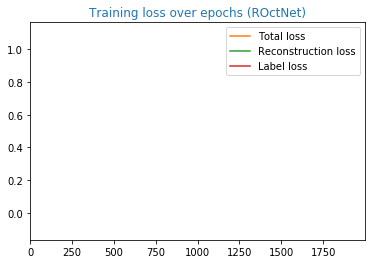

In [13]:
print("Start training ...... ")

if config.save_log:
    fd_log = open('training_log.log', mode='a')
    fd_log.write('\n\nTraining log at '+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    fd_log.write('\n#epoch: {}'.format(config.epochs))
    fd_log.write('\nbatch_size: {}'.format(config.batch_size))
    fd_log.write('\ncuda: {}'.format(config.cuda))
    fd_log.flush()

header = '     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss'
log_template = ' '.join('{:>9s},{:>5.0f}/{:<5.0f},,{:>5.0f}/{:<5.0f},{:>5.0f}/{:<5.0f},{:>9.1f}%,{:>11.2f},{:>11.2f},{:>10.2f}'.split(','))

total_iter = config.epochs * math.ceil(n_samples/config.batch_size) 

if not config.no_plot:
    plot_x = [x for x in range(total_iter)]
    plot_total_loss = [None for x in range(total_iter)]
    plot_recon_loss = [None for x in range(total_iter)]
    plot_label_loss = [None for x in range(total_iter)]
    dyn_plot = DynamicPlot(title='Training loss over epochs (ROctNet)', xdata=plot_x, ydata={'Total_loss':plot_total_loss, 'Reconstruction_loss':plot_recon_loss,'Label_loss':plot_label_loss})
    iter_id = 0
    max_loss = 0
    min_loss = 0

start = time.time()

flag = True

for epoch in range(config.epochs):

    print(header)
    for base in range(1,1+n_samples,incre):
    
        if incre < n_samples or flag:
            flag = False
            #print("Loading data ...... "+str(base), end='', flush=True)
            roct_data = ROctDataset('data/train_1', base, incre)
            train_iter = torch.utils.data.DataLoader(roct_data, batch_size=config.batch_size, shuffle=True, collate_fn=my_collate)
            #valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=200, shuffle=True, collate_fn=my_collate)
            #print("DONE")

        for batch_idx, batch in enumerate(train_iter):
            # Initialize torchfold for *encoding*
            enc_fold = FoldExt(cuda=config.cuda)
            enc_fold_nodes = []     # list of fold nodes for encoding
            # Collect computation nodes recursively from encoding process
            for example in batch:
                enc_fold_nodes.append(ROctNetmodel_32.encode_structure_fold(enc_fold, example))

            # Apply the computations on the encoder model
            #set_trace()
            enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])

            # Split into a list of fold nodes per example
            enc_fold_nodes = torch.split(enc_fold_nodes[0], 1, 0)
            # Initialize torchfold for *decoding*
            dec_fold = FoldExt(cuda=config.cuda)
            # Collect computation nodes recursively from decoding process
            dec_fold_nodes = []
            for example, fnode in zip(batch, enc_fold_nodes):
                root_code = fnode
                dec_fold_nodes.append(ROctNetmodel_32.decode_structure_fold(dec_fold, root_code, example))
                #if epoch==config.epochs-1:
                    #sample_codes_all.append(root_code)
                    #print("finished!!!")

            # Apply the computations on the decoder model
            dec_fold_nodes1,dec_fold_nodes2 = map(list, zip(*dec_fold_nodes))

            recon_loss = dec_fold.apply(decoder, [dec_fold_nodes1])
            label_loss = dec_fold.apply(decoder, [dec_fold_nodes2])

            #set_trace()
                # the first dim of total_loss is for reconstruction and the second for KL divergence
            recon_loss = recon_loss[0].sum() / len(batch)               # avg. reconstruction loss per example
            label_loss = label_loss[0].sum() / len(batch)
            total_loss = recon_loss + label_loss
            #set_trace()

            if total_loss.data.cpu().numpy() < 500:
                for param_group in encoder_opt.param_groups:
                    param_group['lr'] = 1e-4
                for param_group in decoder_opt.param_groups:
                    param_group['lr'] = 1e-4


            # Do parameter optimization
            encoder_opt.zero_grad()
            decoder_opt.zero_grad()
            total_loss.backward()
            encoder_opt.step()
            decoder_opt.step()

            # Report statistics
            if batch_idx % config.show_log_every == 0:
                print(log_template.format(strftime("%H:%M:%S",time.gmtime(time.time()-start)),
                    epoch, config.epochs, math.ceil(base/incre) , math.ceil(n_samples/incre) ,1+batch_idx, len(train_iter),
                    100. * (1+batch_idx+len(train_iter)*epoch) / (len(train_iter)*config.epochs),
                    recon_loss.data[0], label_loss.data[0], total_loss.data[0]))
            # Plot losses
            if not config.no_plot and epoch>=0:
                plot_total_loss[iter_id] = total_loss.data[0]
                plot_recon_loss[iter_id] = recon_loss.data[0]
                plot_label_loss[iter_id] = label_loss.data[0]
                max_loss = max(max_loss, total_loss.data[0], recon_loss.data[0], label_loss.data[0])
                min_loss = min(min_loss, total_loss.data[0], recon_loss.data[0], label_loss.data[0])
                dyn_plot.setxlim(0., (iter_id+1)*1.05)
                dyn_plot.setylim(min_loss*1.05, max_loss*1.05)
                dyn_plot.update_plots(ydata={'Total_loss':plot_total_loss, 'Reconstruction_loss':plot_recon_loss,  'Label_loss':plot_label_loss})
                iter_id += 1

        # Save snapshots of the models being trained
        if config.save_snapshot and (epoch+1) % config.save_snapshot_every == 0 :
            print("Saving snapshots of the models ...... ", end='', flush=True)
            torch.save(encoder, 'snapshots/vae_encoder_model_epoch_{}_loss_{:.2f}.pkl'.format(epoch+1, total_loss.data[0]))
            torch.save(decoder, 'snapshots/vae_decoder_model_epoch_{}_loss_{:.2f}.pkl'.format(epoch+1, total_loss.data[0]))
            print("DONE")
        # Save training log
        if config.save_log and (epoch+1) % config.save_log_every == 0 : 
            fd_log = open('training_log.log', mode='a')
            fd_log.write('\nepoch:{} recon_loss:{:.2f} kld_loss:{:.2f} total_loss:{:.2f}'.format(epoch+1, recon_loss.data[0], kldiv_loss.data[0], total_loss.data[0]))
            fd_log.close()

In [ ]:
# Save the final models
print("Saving final models ...... ", end='', flush=True)
torch.save(encoder, 'models/ae_encoder_plane_128_32.pkl')
torch.save(decoder, 'models/ae_decoder_plane_128_32.pkl')
print("DONE")

In [ ]:
from torch.autograd import Variable
def encode_structure(model, tree):
    """
    Encode a tree into a code
    """
    def encode_node(node,l):
        if node.is_leaf():
            if not node.is_empty_leaf():
                return model.boxEncoder(Variable(node.fea.cuda()))
            else:
                return model.boxEncoder2(Variable(node.fea.cuda()))
        elif node.is_expand():
            child = []
            for i in range(8):
                child.append(encode_node(node.child[i],l+1))
            mycode = 'model.adjEncoder'+str(l)+'(child[0], child[1],child[2],child[3],child[4],child[5],child[6],child[7])'
            return eval(mycode)

    encoding = encode_node(tree.root,1)
    root_code = model.sampleEncoder(encoding)

    return root_code

In [ ]:
from torch.autograd import Variable
def decode_structure(model, root_code):
    """
    Decode a root code into boxes
    """
    decode = model.sampleDecoder(root_code)
    stack = [decode]
    boxes = []
    ops = []
    depth = [1]

    while len(stack) > 0:
        f = stack.pop()
        d = depth.pop()
        label_prob = model.nodeClassifier(f)
        _, label = torch.max(label_prob,1)
        label = label.data.cpu().numpy()
#         print(label)
#         print(label_prob)
        ops.append(label)
        
        if label == 3: # NON-LEAF
            mycode = 'model.adjDecoder'+str(d)+'(f)'
            child_feature1,child_feature2,child_feature3,child_feature4,child_feature5,child_feature6,child_feature7,child_feature8 = eval(mycode) 
            #print('non-leaf')               
            
            stack.append(child_feature8)
            stack.append(child_feature7)
            stack.append(child_feature6)
            stack.append(child_feature5)
            stack.append(child_feature4)
            stack.append(child_feature3)
            stack.append(child_feature2)
            stack.append(child_feature1)
            
            for i in range(8):
                depth.append(d+1)

                
        else:  # LEAF
            #print('leaf')
            reBox = model.boxDecoder(f)
            reBoxes = [reBox]
            boxes.extend(reBox)

    return boxes, ops

In [ ]:
def decode_structure2(model, root_code, tree):
    """
    Decode a root code into boxes
    """
    decode = model.sampleDecoder(root_code)
    stack = [decode]
    boxes = []
    ops = []
    depth = [tree.root]
    depth2 = [1]
    
    while len(stack) > 0:
        f = stack.pop()
        d = depth.pop()
        d2 = depth2.pop()
  
        ops.append(d.label.cpu().numpy())
    
        if d.is_expand():  # NON-LEAF
            mycode = 'model.adjDecoder'+str(d2)+'(f)'
            child_feature1,child_feature2,child_feature3,child_feature4,child_feature5,child_feature6,child_feature7,child_feature8 = eval(mycode) 
            #print('non-leaf')          
            #print('non-leaf')
            stack.append(child_feature8)
            stack.append(child_feature7)
            stack.append(child_feature6)
            stack.append(child_feature5)
            stack.append(child_feature4)
            stack.append(child_feature3)
            stack.append(child_feature2)
            stack.append(child_feature1)

            for i in range(7,-1,-1):
                depth.append(d.child[i])
            
            for i in range(8):
                depth2.append(d2+1)

                
        else:  # LEAF
            #print('leaf')
            reBox = model.boxDecoder(f)
            reBoxes = [reBox]
            boxes.extend(reBox)

    return boxes, ops

In [ ]:
#train samples reconstruction
encoder = encoder.eval()
decoder = decoder.eval()

import scipy.io as sio
recons_all = []
ops_all = []
for i in range(0,24):
    code = encode_structure(encoder, roct_data.trees[i])
    recons,ops = decode_structure(decoder, code)
    recons_all.append(torch.cat(recons,0).data.cpu().numpy()>0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all},do_compression=True)

In [ ]:
#train samples reconstruction with GT octree structure
encoder = encoder.eval()
decoder = decoder.eval()
import scipy.io as sio
recons_all = []
ops_all = []
for i in range(2):
    code = encode_structure(encoder, roct_data.trees[i])
    recons,ops = decode_structure2(decoder, code, roct_data.trees[i])
    recons_all.append(torch.cat(recons,0).data.cpu().numpy())
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all})

In [ ]:
print(recons_all[0].shape)

In [ ]:
print(len(ops_all[0]))

In [ ]:
print(recons_all[0].max())

In [ ]:
#morphing
encoder = encoder.eval()
decoder = decoder.eval()

import scipy.io as sio
import numpy
recons_all = []
ops_all = []
for i in numpy.arange(0,1,0.1):
    code1 = encode_structure(encoder, roct_data.trees[0*12])
    code2 = encode_structure(encoder, roct_data.trees[1*12])
    code = code1.mul(i) + code2.mul(1-i)
    recons,ops = decode_structure(decoder, code)
    recons_all.append(torch.cat(recons,0).data.cpu().numpy()>0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/morphing.mat', {'morphing_all':recons_all, 'morphing_ops_all':ops_all},do_compression=True)

In [ ]:
#read test samples
test_data = ROctDataset('/data/juncheng/shapenetcorev2/airplane/128_32_vox/shuffled_test_1',1 , 809)
#roct_data.trees = roct_data.trees[0:-1:12]
print("DONE")

len(test_data.trees)

In [ ]:
#test samples reconstruction
encoder = encoder.eval()
decoder = decoder.eval()

import scipy.io as sio
recons_all = []
ops_all = []
for i in range(len(test_data.trees)): #len(test_data.trees)
    code = encode_structure(encoder, test_data.trees[i])
    recons,ops = decode_structure(decoder, code)
    recons_all.append(torch.cat(recons,0).data.cpu().numpy()>=0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/test_reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all},do_compression=True)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(str(count_parameters(encoder)/1024/1024)+'M')
print(str(count_parameters(decoder)/1024/1024)+'M')

2.8032913208007812M
3.3380651473999023M
